In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import os
import gym
%matplotlib inline
from IPython import display

In [ ]:
class ActorNetwork(nn.Module):

    def __init__(self,input_size,hidden_size,action_size):
        super(ActorNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size,hidden_size)
        self.fc2 = nn.Linear(hidden_size,hidden_size)
        self.fc3 = nn.Linear(hidden_size,action_size)

    def forward(self,x):
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        out = F.log_softmax(self.fc3(out))
        return out

class ValueNetwork(nn.Module):

    def __init__(self,input_size,hidden_size,output_size):
        super(ValueNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size,hidden_size)
        self.fc2 = nn.Linear(hidden_size,hidden_size)
        self.fc3 = nn.Linear(hidden_size,output_size)

    def forward(self,x):
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

In [1]:
def run(random_seed):
    
    torch.cuda.manual_seed(random_seed)
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)
    random.seed(random_seed)

    STEP = 500
    SAMPLE_NUMS = 30

    def roll_out(actor_network,task,sample_nums,value_network,init_state):
        #task.reset()
        states = []
        actions = []
        rewards = []
        is_done = False
        final_r = 0
        state = init_state

        for j in range(sample_nums):
            states.append(state)
            log_softmax_action = actor_network(Variable(torch.Tensor([state])))
            softmax_action = torch.exp(log_softmax_action)
            action = np.random.choice(ACTION_DIM,p=softmax_action.cpu().data.numpy()[0])
            one_hot_action = [int(k == action) for k in range(ACTION_DIM)]
            next_state,reward,done,_ = task.step(action)
            #fix_reward = -10 if done else 1
            actions.append(one_hot_action)
            rewards.append(reward)
            final_state = next_state
            state = next_state
            if done:
                is_done = True
                state = task.reset()
                break
        if not is_done:
            final_r = value_network(Variable(torch.Tensor([final_state]))).cpu().data.numpy()

        return states,actions,rewards,final_r,state

    def discount_reward(r, gamma, final_r):
        discounted_r = np.zeros_like(r)
        running_add = final_r
        for t in reversed(range(0, len(r))):
            running_add = running_add * gamma.detach().numpy() + r[t]
            discounted_r[t] = running_add
        return discounted_r

    def discount_reward_grad(r, gamma, final_r):
        discounted_r = torch.zeros_like(torch.tensor(rewards))
        running_add = torch.reshape(torch.tensor(final_r), (1,1))
        for t in reversed(range(0, len(rewards))):
            running_add = running_add * gamma + torch.tensor(rewards[t])
            discounted_r[t] = running_add
        return discounted_r

    # gym_name = "Pong-ram-v0"
    # gym_name = "MountainCar-v0"
    gym_name = "CartPole-v1"

    # init a task generator for data fetching
    task = gym.make(gym_name)
    task.seed(random_seed)
    init_state = task.reset()

    discrete = isinstance(task.action_space, gym.spaces.Discrete)
    STATE_DIM = task.observation_space.shape[0]
    ACTION_DIM = task.action_space.n if discrete else task.action_space.shape[0]

    # init value network
    value_network = ValueNetwork(input_size = STATE_DIM,hidden_size = 40,output_size = 1)
    value_network_optim = torch.optim.Adam(value_network.parameters(),lr=0.01)

    # init actor network
    actor_network = ActorNetwork(STATE_DIM,40,ACTION_DIM)
    actor_network_optim = torch.optim.Adam(actor_network.parameters(),lr = 0.01)

    steps =[]
    task_episodes =[]
    test_results =[]

    pi_list = []
    value_list = []
    expected_return_list = []

    gamma_buffer = []
    angle_buffer = []
    target_value_buffer = []
    estimate_value_buffer = []

    gamma = torch.tensor(0.99, requires_grad=True)

    for step in range(STEP):
        states,actions,rewards,final_r,current_state = roll_out(actor_network,task,SAMPLE_NUMS,value_network,init_state)
        init_state = current_state
        actions_var = Variable(torch.Tensor(actions).view(-1,ACTION_DIM))
        states_var = Variable(torch.Tensor(states).view(-1,STATE_DIM))

        actor_network.zero_grad()
        actor_network_optim.zero_grad()
        value_network.zero_grad()
        value_network_optim.zero_grad()

        # train actor network
        log_softmax_actions = actor_network(states_var)
        vs = value_network(states_var).detach()
        # calculate qs
        qs = Variable(torch.Tensor(discount_reward(rewards,gamma,final_r)))

        advantages = qs - vs
        actor_network_loss = - torch.mean(torch.sum(log_softmax_actions*actions_var,1)* advantages)
        actor_network_loss.backward(retain_graph=True)
        torch.nn.utils.clip_grad_norm_(actor_network.parameters(),0.5)

        # train value network
        target_values = qs
        values = value_network(states_var)
        criterion = nn.MSELoss()
        value_network_loss = criterion(values.view(-1),target_values)
        value_network_loss.backward(retain_graph=True)
        torch.nn.utils.clip_grad_norm_(value_network.parameters(),0.5)

        pi_ = torch.mean(log_softmax_actions*actions_var)
        values_ = (values).pow(2).mean()
        return_ = discount_reward_grad(rewards,gamma,final_r).mean()
        f, f1, f2 = compute_df_dtheta(pi_, values_, return_, actor_network, value_network, gamma)

        actor_network_optim.step()
        value_network_optim.step()
        
        gamma_buffer.append(gamma)

        # Testing
        if (step + 1) % 10== 0:
            result = 0
            test_task = gym.make(gym_name)
            for test_epi in range(10):
                state = test_task.reset()
                for test_step in range(500):
                    softmax_action = torch.exp(actor_network(Variable(torch.Tensor([state]))))
                    action = np.argmax(softmax_action.data.numpy()[0])
                    next_state,reward,done,_ = test_task.step(action)
                    result += reward
                    state = next_state
                    if done:
                        break
            print("step:",step+1,"test result:",result/10.0)
            steps.append(step+1)
            test_results.append(result/10)
            if test_results[-1] > task.spec.reward_threshold:
                break

        target_value_buffer.append(target_values.numpy().mean())
        estimate_value_buffer.append(values.detach().numpy().mean())

    estimate_value_buffer = np.array(estimate_value_buffer)
    target_value_buffer = np.array(target_value_buffer)
    
    return gamma_buffer, angle_buffer, target_value_buffer, estimate_value_buffer, test_resultsd

In [2]:
def mv(x, w=3):
    return np.convolve(x, np.ones(w), 'valid') / w

/home/aaron/anaconda3/envs/PT17/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


step: 10 test result: 34.9
step: 20 test result: 51.2
step: 30 test result: 89.0
step: 40 test result: 236.6
step: 50 test result: 209.5
step: 60 test result: 130.5
step: 70 test result: 127.6
step: 80 test result: 85.0
step: 90 test result: 110.2
step: 100 test result: 126.3
step: 110 test result: 239.3
step: 120 test result: 245.7
step: 130 test result: 106.6
step: 140 test result: 78.8
step: 150 test result: 42.5
step: 160 test result: 103.5
step: 170 test result: 270.4
step: 180 test result: 500.0


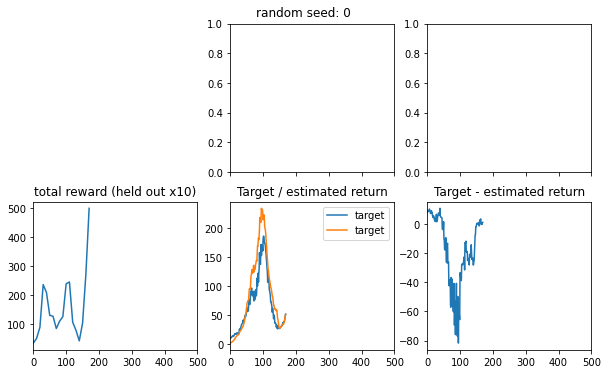

/home/aaron/anaconda3/envs/PT17/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


step: 10 test result: 218.7
step: 20 test result: 201.8
step: 30 test result: 123.0
step: 40 test result: 281.6
step: 50 test result: 57.2
step: 60 test result: 136.1
step: 70 test result: 182.8
step: 80 test result: 116.4
step: 90 test result: 291.5
step: 100 test result: 221.9
step: 110 test result: 225.9
step: 120 test result: 500.0


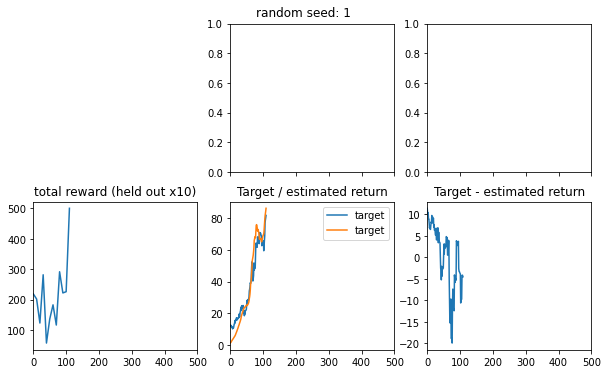

/home/aaron/anaconda3/envs/PT17/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


step: 10 test result: 9.3
step: 20 test result: 9.7
step: 30 test result: 9.4
step: 40 test result: 10.4
step: 50 test result: 10.9
step: 60 test result: 13.4
step: 70 test result: 17.3
step: 80 test result: 18.8
step: 90 test result: 24.8
step: 100 test result: 33.3
step: 110 test result: 74.7
step: 120 test result: 72.0
step: 130 test result: 16.1
step: 140 test result: 9.6
step: 150 test result: 9.1
step: 160 test result: 9.1
step: 170 test result: 9.1
step: 180 test result: 9.0
step: 190 test result: 9.5
step: 200 test result: 9.6
step: 210 test result: 9.3
step: 220 test result: 9.2
step: 230 test result: 9.0
step: 240 test result: 18.2
step: 250 test result: 132.5
step: 260 test result: 63.4
step: 270 test result: 100.7
step: 280 test result: 60.1
step: 290 test result: 108.4
step: 300 test result: 118.6
step: 310 test result: 100.0
step: 320 test result: 123.3
step: 330 test result: 79.9
step: 340 test result: 56.7
step: 350 test result: 66.6
step: 360 test result: 77.6
step: 37

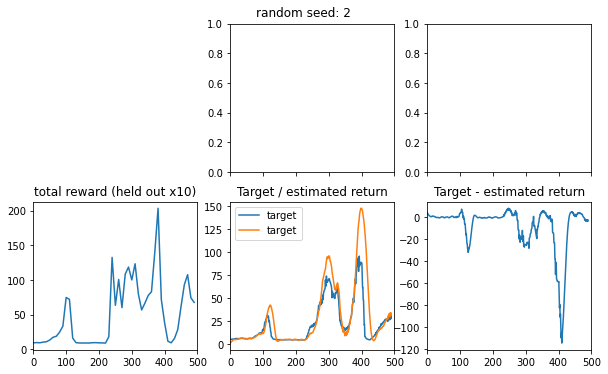

/home/aaron/anaconda3/envs/PT17/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


step: 10 test result: 9.3
step: 20 test result: 9.3
step: 30 test result: 17.9
step: 40 test result: 40.2
step: 50 test result: 41.8
step: 60 test result: 43.9
step: 70 test result: 99.1
step: 80 test result: 195.9
step: 90 test result: 278.0
step: 100 test result: 336.8
step: 110 test result: 143.6
step: 120 test result: 159.1
step: 130 test result: 126.5
step: 140 test result: 39.2
step: 150 test result: 27.6
step: 160 test result: 21.9
step: 170 test result: 21.3
step: 180 test result: 22.7
step: 190 test result: 54.8
step: 200 test result: 129.3
step: 210 test result: 180.1
step: 220 test result: 500.0


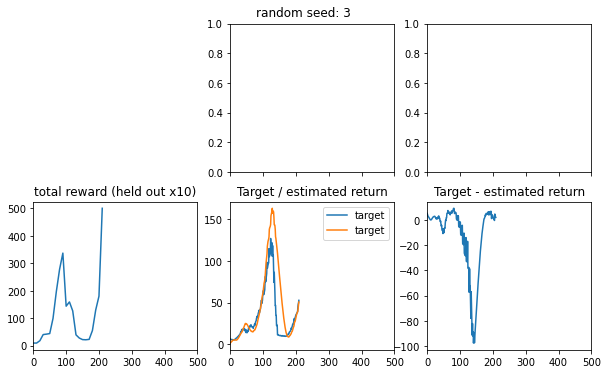

/home/aaron/anaconda3/envs/PT17/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


step: 10 test result: 9.1
step: 20 test result: 9.4
step: 30 test result: 9.2
step: 40 test result: 9.1
step: 50 test result: 12.8
step: 60 test result: 13.5
step: 70 test result: 18.1
step: 80 test result: 24.9
step: 90 test result: 57.9
step: 100 test result: 200.3
step: 110 test result: 126.9
step: 120 test result: 299.8
step: 130 test result: 306.4
step: 140 test result: 130.6
step: 150 test result: 85.5
step: 160 test result: 157.9
step: 170 test result: 500.0


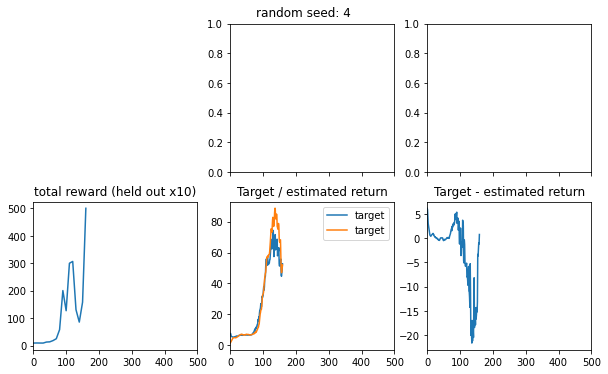

/home/aaron/anaconda3/envs/PT17/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


step: 10 test result: 12.9
step: 20 test result: 23.6
step: 30 test result: 66.8
step: 40 test result: 82.2
step: 50 test result: 77.0
step: 60 test result: 63.1
step: 70 test result: 161.5
step: 80 test result: 139.6
step: 90 test result: 89.5
step: 100 test result: 179.2
step: 110 test result: 320.8
step: 120 test result: 103.6
step: 130 test result: 120.6
step: 140 test result: 145.3
step: 150 test result: 185.5
step: 160 test result: 141.3
step: 170 test result: 136.6
step: 180 test result: 175.9
step: 190 test result: 488.2


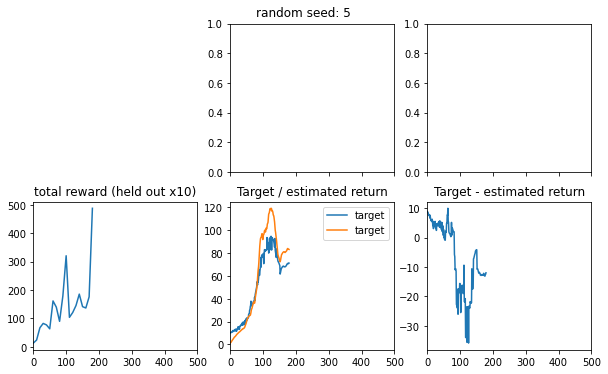

/home/aaron/anaconda3/envs/PT17/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


step: 10 test result: 9.6
step: 20 test result: 9.4
step: 30 test result: 16.6
step: 40 test result: 45.2
step: 50 test result: 175.3
step: 60 test result: 49.4
step: 70 test result: 401.8
step: 80 test result: 442.5
step: 90 test result: 122.0
step: 100 test result: 150.5
step: 110 test result: 105.0
step: 120 test result: 123.7
step: 130 test result: 124.0
step: 140 test result: 41.2
step: 150 test result: 78.3
step: 160 test result: 118.3
step: 170 test result: 117.4
step: 180 test result: 132.3
step: 190 test result: 321.9
step: 200 test result: 221.7
step: 210 test result: 114.9
step: 220 test result: 37.7
step: 230 test result: 43.5
step: 240 test result: 106.0
step: 250 test result: 107.2
step: 260 test result: 118.2
step: 270 test result: 175.8
step: 280 test result: 222.5
step: 290 test result: 236.2
step: 300 test result: 187.5
step: 310 test result: 148.7
step: 320 test result: 114.1
step: 330 test result: 111.9
step: 340 test result: 101.8
step: 350 test result: 99.4
step: 

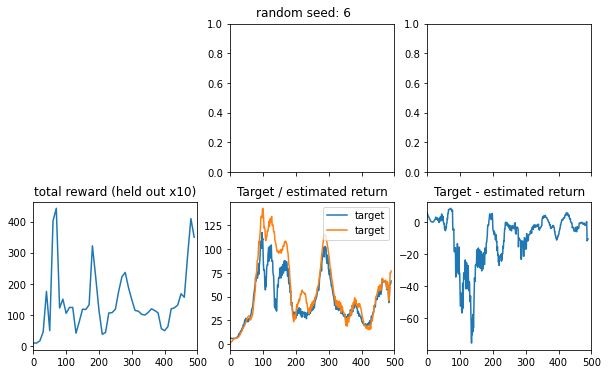

/home/aaron/anaconda3/envs/PT17/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


step: 10 test result: 9.2
step: 20 test result: 9.5
step: 30 test result: 9.5
step: 40 test result: 9.2
step: 50 test result: 9.4
step: 60 test result: 9.2
step: 70 test result: 13.5
step: 80 test result: 21.2
step: 90 test result: 38.8
step: 100 test result: 228.8
step: 110 test result: 89.4
step: 120 test result: 129.4
step: 130 test result: 342.9
step: 140 test result: 174.5
step: 150 test result: 190.4
step: 160 test result: 155.9
step: 170 test result: 109.0
step: 180 test result: 104.4
step: 190 test result: 145.7
step: 200 test result: 189.0
step: 210 test result: 387.4
step: 220 test result: 481.4


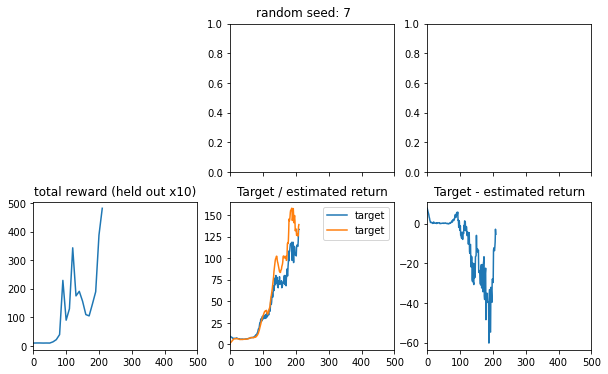

/home/aaron/anaconda3/envs/PT17/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


step: 10 test result: 9.2
step: 20 test result: 14.8
step: 30 test result: 74.3
step: 40 test result: 116.4
step: 50 test result: 65.4
step: 60 test result: 61.8
step: 70 test result: 238.7
step: 80 test result: 105.9
step: 90 test result: 128.7
step: 100 test result: 261.3
step: 110 test result: 403.4
step: 120 test result: 184.1
step: 130 test result: 115.1
step: 140 test result: 121.4
step: 150 test result: 52.9
step: 160 test result: 43.0
step: 170 test result: 276.5
step: 180 test result: 37.5
step: 190 test result: 61.8
step: 200 test result: 395.8
step: 210 test result: 224.7
step: 220 test result: 223.6
step: 230 test result: 260.1
step: 240 test result: 188.1
step: 250 test result: 213.4
step: 260 test result: 232.9
step: 270 test result: 190.0
step: 280 test result: 165.4
step: 290 test result: 173.3
step: 300 test result: 165.7
step: 310 test result: 129.1
step: 320 test result: 198.3
step: 330 test result: 282.6
step: 340 test result: 266.4
step: 350 test result: 107.8
step

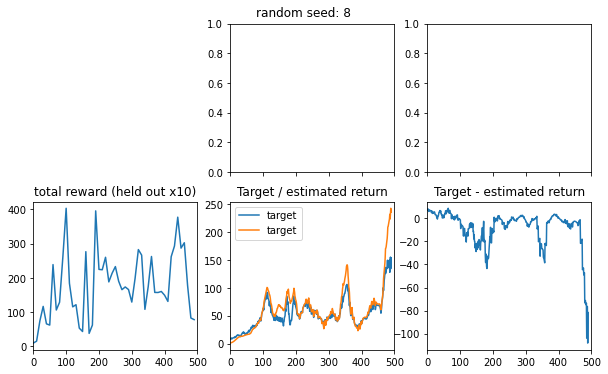

/home/aaron/anaconda3/envs/PT17/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


step: 10 test result: 10.0
step: 20 test result: 9.0
step: 30 test result: 9.5
step: 40 test result: 9.2
step: 50 test result: 9.6
step: 60 test result: 36.3
step: 70 test result: 57.6
step: 80 test result: 98.5
step: 90 test result: 78.0
step: 100 test result: 160.8
step: 110 test result: 113.6
step: 120 test result: 239.3
step: 130 test result: 246.9
step: 140 test result: 62.5
step: 150 test result: 63.4
step: 160 test result: 47.4
step: 170 test result: 51.8
step: 180 test result: 58.2
step: 190 test result: 41.0
step: 200 test result: 41.4
step: 210 test result: 38.5
step: 220 test result: 54.1
step: 230 test result: 67.4
step: 240 test result: 65.7
step: 250 test result: 50.8
step: 260 test result: 45.3
step: 270 test result: 41.2
step: 280 test result: 30.8
step: 290 test result: 26.6
step: 300 test result: 23.9
step: 310 test result: 25.7
step: 320 test result: 22.4
step: 330 test result: 25.2
step: 340 test result: 27.2
step: 350 test result: 39.4
step: 360 test result: 39.2
s

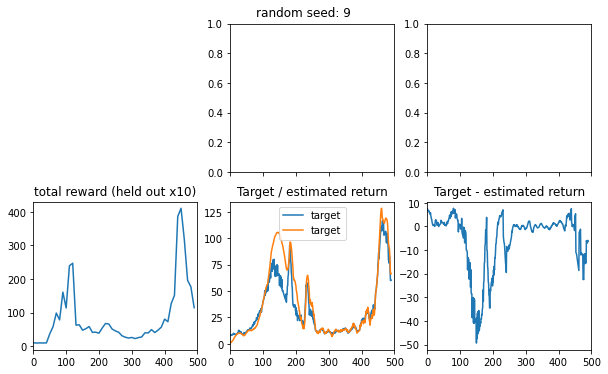

/home/aaron/anaconda3/envs/PT17/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


step: 10 test result: 59.0
step: 20 test result: 99.7
step: 30 test result: 58.3
step: 40 test result: 38.8
step: 50 test result: 160.2
step: 60 test result: 214.3
step: 70 test result: 207.1
step: 80 test result: 91.2
step: 90 test result: 144.0
step: 100 test result: 62.7
step: 110 test result: 32.8
step: 120 test result: 26.9
step: 130 test result: 29.4
step: 140 test result: 47.4
step: 150 test result: 118.6
step: 160 test result: 349.4
step: 170 test result: 500.0


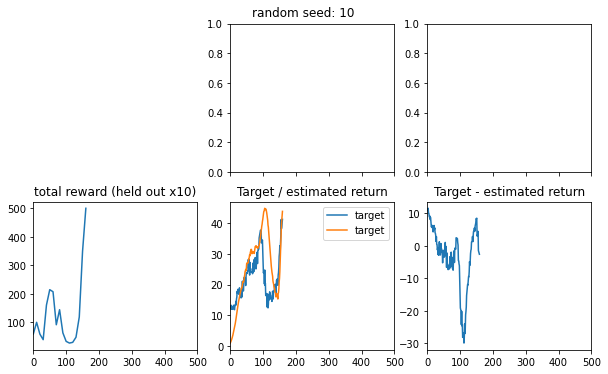

/home/aaron/anaconda3/envs/PT17/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


step: 10 test result: 14.1
step: 20 test result: 72.1
step: 30 test result: 47.3
step: 40 test result: 36.4
step: 50 test result: 36.7
step: 60 test result: 87.6
step: 70 test result: 78.1
step: 80 test result: 173.4
step: 90 test result: 267.5
step: 100 test result: 113.4
step: 110 test result: 122.8
step: 120 test result: 188.9
step: 130 test result: 197.2
step: 140 test result: 205.4
step: 150 test result: 40.7
step: 160 test result: 21.8
step: 170 test result: 9.7
step: 180 test result: 500.0


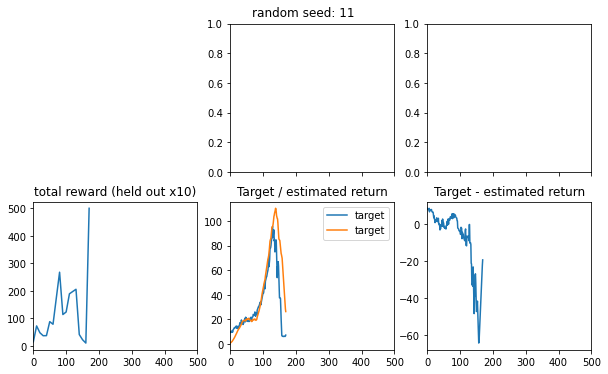

/home/aaron/anaconda3/envs/PT17/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


step: 10 test result: 16.4
step: 20 test result: 16.8
step: 30 test result: 39.0
step: 40 test result: 66.2
step: 50 test result: 56.9
step: 60 test result: 36.1
step: 70 test result: 135.7
step: 80 test result: 180.6
step: 90 test result: 173.8
step: 100 test result: 98.7
step: 110 test result: 112.3
step: 120 test result: 135.0
step: 130 test result: 121.6
step: 140 test result: 20.5
step: 150 test result: 30.6
step: 160 test result: 99.7
step: 170 test result: 174.3
step: 180 test result: 252.9
step: 190 test result: 116.2
step: 200 test result: 71.5
step: 210 test result: 38.4
step: 220 test result: 31.0
step: 230 test result: 30.1
step: 240 test result: 28.2
step: 250 test result: 41.6
step: 260 test result: 57.1
step: 270 test result: 61.8
step: 280 test result: 86.7
step: 290 test result: 106.2
step: 300 test result: 111.4
step: 310 test result: 168.0
step: 320 test result: 499.6


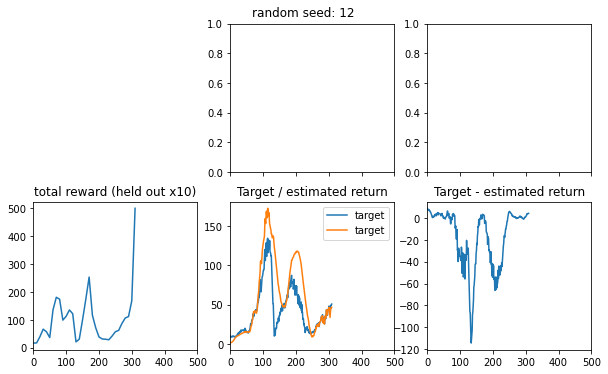

/home/aaron/anaconda3/envs/PT17/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


step: 10 test result: 9.2
step: 20 test result: 29.6
step: 30 test result: 56.3
step: 40 test result: 72.0
step: 50 test result: 76.9
step: 60 test result: 97.1
step: 70 test result: 98.3
step: 80 test result: 204.2
step: 90 test result: 81.8
step: 100 test result: 114.1
step: 110 test result: 367.1
step: 120 test result: 350.9
step: 130 test result: 295.0
step: 140 test result: 413.7
step: 150 test result: 142.0
step: 160 test result: 120.2
step: 170 test result: 500.0


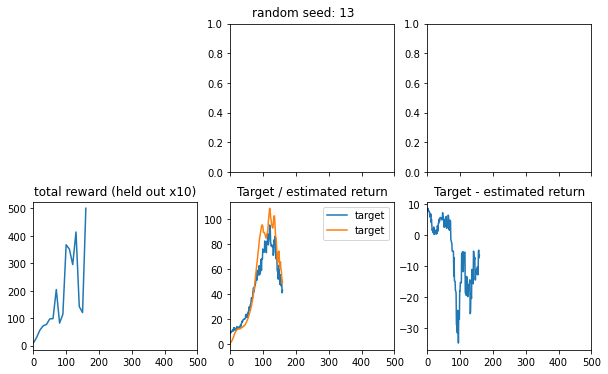

/home/aaron/anaconda3/envs/PT17/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


step: 10 test result: 18.2
step: 20 test result: 28.5
step: 30 test result: 26.7
step: 40 test result: 32.4
step: 50 test result: 34.9
step: 60 test result: 37.7
step: 70 test result: 61.8
step: 80 test result: 56.9
step: 90 test result: 61.1
step: 100 test result: 93.6
step: 110 test result: 84.2
step: 120 test result: 53.3
step: 130 test result: 46.8
step: 140 test result: 52.3
step: 150 test result: 18.8
step: 160 test result: 27.2
step: 170 test result: 38.3
step: 180 test result: 55.5
step: 190 test result: 53.9
step: 200 test result: 92.1
step: 210 test result: 61.5
step: 220 test result: 189.4
step: 230 test result: 112.3
step: 240 test result: 227.3
step: 250 test result: 130.5
step: 260 test result: 274.9
step: 270 test result: 290.5
step: 280 test result: 277.3
step: 290 test result: 231.8
step: 300 test result: 198.3
step: 310 test result: 248.3
step: 320 test result: 174.2
step: 330 test result: 107.4
step: 340 test result: 106.0
step: 350 test result: 132.8
step: 360 test 

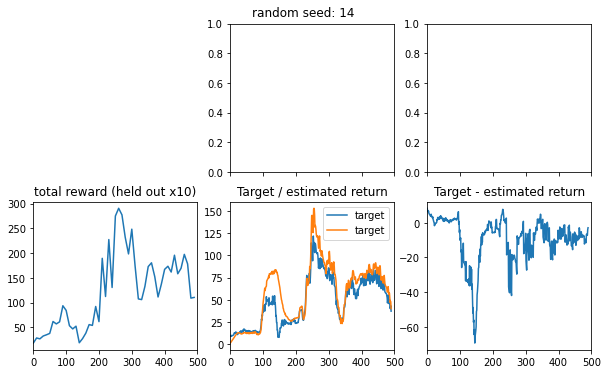

/home/aaron/anaconda3/envs/PT17/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


step: 10 test result: 9.3
step: 20 test result: 9.9
step: 30 test result: 9.5
step: 40 test result: 9.5
step: 50 test result: 9.0
step: 60 test result: 9.4
step: 70 test result: 9.5
step: 80 test result: 9.3
step: 90 test result: 9.6
step: 100 test result: 9.1
step: 110 test result: 9.6
step: 120 test result: 8.8
step: 130 test result: 9.1
step: 140 test result: 9.3
step: 150 test result: 9.5
step: 160 test result: 9.1
step: 170 test result: 9.6
step: 180 test result: 9.4
step: 190 test result: 9.3
step: 200 test result: 9.5
step: 210 test result: 9.4
step: 220 test result: 8.9
step: 230 test result: 9.7
step: 240 test result: 9.5
step: 250 test result: 9.3
step: 260 test result: 9.3
step: 270 test result: 9.7
step: 280 test result: 9.3
step: 290 test result: 9.4
step: 300 test result: 9.5
step: 310 test result: 9.4
step: 320 test result: 9.2
step: 330 test result: 9.4
step: 340 test result: 9.5
step: 350 test result: 9.2
step: 360 test result: 9.3
step: 370 test result: 9.3
step: 380 

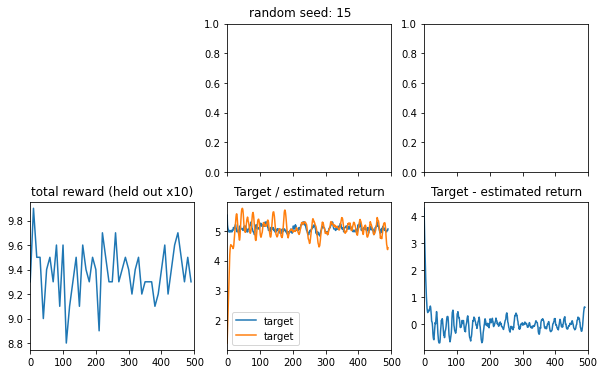

/home/aaron/anaconda3/envs/PT17/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


step: 10 test result: 9.9
step: 20 test result: 9.0
step: 30 test result: 13.4
step: 40 test result: 26.3
step: 50 test result: 23.6
step: 60 test result: 26.0
step: 70 test result: 76.0
step: 80 test result: 180.1
step: 90 test result: 166.2
step: 100 test result: 185.1
step: 110 test result: 59.2
step: 120 test result: 35.0
step: 130 test result: 28.0
step: 140 test result: 73.9
step: 150 test result: 161.0
step: 160 test result: 236.7
step: 170 test result: 225.2
step: 180 test result: 135.0
step: 190 test result: 146.5
step: 200 test result: 71.5
step: 210 test result: 114.8
step: 220 test result: 136.6
step: 230 test result: 135.9
step: 240 test result: 389.8
step: 250 test result: 500.0


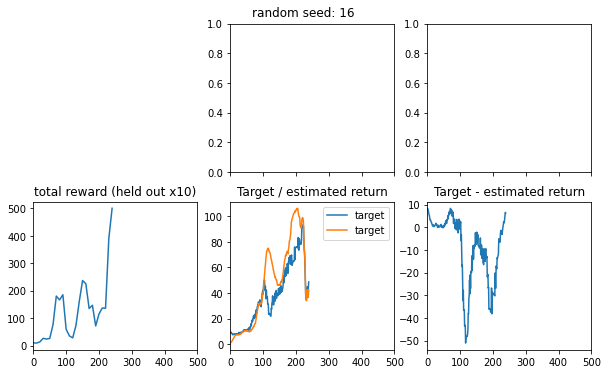

/home/aaron/anaconda3/envs/PT17/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


step: 10 test result: 9.9
step: 20 test result: 15.4
step: 30 test result: 24.5
step: 40 test result: 25.2
step: 50 test result: 34.7
step: 60 test result: 40.5
step: 70 test result: 40.1
step: 80 test result: 79.9
step: 90 test result: 144.2
step: 100 test result: 97.7
step: 110 test result: 66.7
step: 120 test result: 145.5
step: 130 test result: 371.2
step: 140 test result: 65.1
step: 150 test result: 23.7
step: 160 test result: 27.1
step: 170 test result: 63.0
step: 180 test result: 352.0
step: 190 test result: 153.0
step: 200 test result: 313.5
step: 210 test result: 172.9
step: 220 test result: 56.6
step: 230 test result: 36.8
step: 240 test result: 51.5
step: 250 test result: 175.3
step: 260 test result: 288.0
step: 270 test result: 120.4
step: 280 test result: 134.3
step: 290 test result: 143.1
step: 300 test result: 137.0
step: 310 test result: 111.1
step: 320 test result: 127.9
step: 330 test result: 276.0
step: 340 test result: 379.1
step: 350 test result: 379.2
step: 360 te

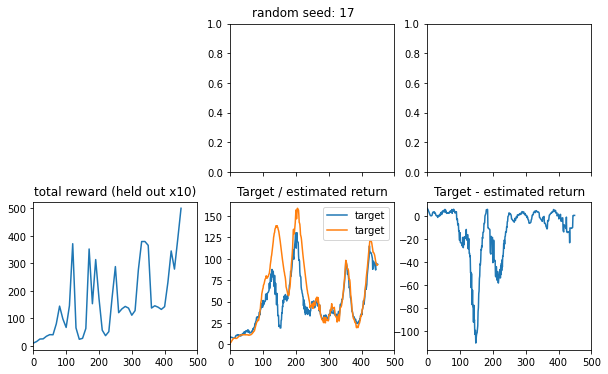

/home/aaron/anaconda3/envs/PT17/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


step: 10 test result: 9.6
step: 20 test result: 9.9
step: 30 test result: 9.3
step: 40 test result: 17.2
step: 50 test result: 24.3
step: 60 test result: 27.6
step: 70 test result: 170.5
step: 80 test result: 53.7
step: 90 test result: 148.1
step: 100 test result: 434.7
step: 110 test result: 442.5
step: 120 test result: 145.1
step: 130 test result: 78.6
step: 140 test result: 56.9
step: 150 test result: 94.9
step: 160 test result: 119.9
step: 170 test result: 103.2
step: 180 test result: 63.5
step: 190 test result: 97.2
step: 200 test result: 142.3
step: 210 test result: 489.5


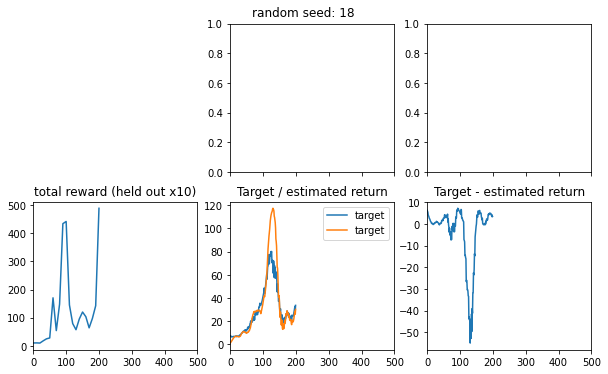

/home/aaron/anaconda3/envs/PT17/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


step: 10 test result: 25.9
step: 20 test result: 9.4
step: 30 test result: 9.3
step: 40 test result: 26.3
step: 50 test result: 71.2
step: 60 test result: 86.9
step: 70 test result: 57.0
step: 80 test result: 46.0
step: 90 test result: 59.4
step: 100 test result: 157.8
step: 110 test result: 172.5
step: 120 test result: 158.5
step: 130 test result: 78.0
step: 140 test result: 113.7
step: 150 test result: 71.7
step: 160 test result: 105.9
step: 170 test result: 227.9
step: 180 test result: 145.5
step: 190 test result: 500.0


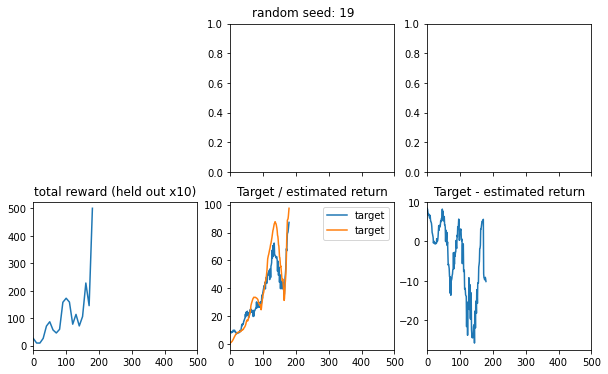

/home/aaron/anaconda3/envs/PT17/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


step: 10 test result: 9.3
step: 20 test result: 9.8
step: 30 test result: 14.2
step: 40 test result: 41.6
step: 50 test result: 53.0
step: 60 test result: 144.5
step: 70 test result: 231.2
step: 80 test result: 158.1
step: 90 test result: 267.4
step: 100 test result: 500.0


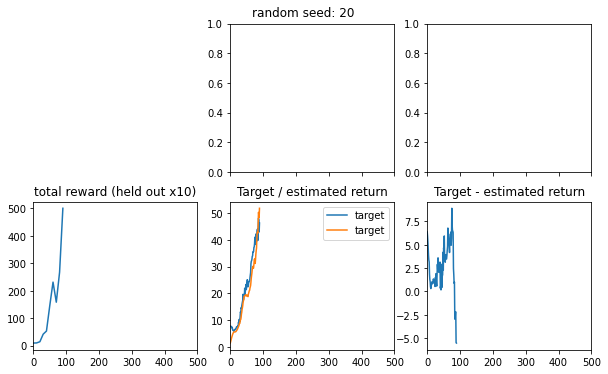

/home/aaron/anaconda3/envs/PT17/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


step: 10 test result: 55.0
step: 20 test result: 40.3
step: 30 test result: 62.2
step: 40 test result: 127.5
step: 50 test result: 44.9
step: 60 test result: 60.4
step: 70 test result: 244.5
step: 80 test result: 34.7
step: 90 test result: 21.7
step: 100 test result: 29.3
step: 110 test result: 31.2
step: 120 test result: 59.1
step: 130 test result: 59.5
step: 140 test result: 221.4
step: 150 test result: 75.3
step: 160 test result: 51.1
step: 170 test result: 30.3
step: 180 test result: 37.1
step: 190 test result: 71.1
step: 200 test result: 69.0
step: 210 test result: 82.0
step: 220 test result: 88.7
step: 230 test result: 80.9
step: 240 test result: 80.1
step: 250 test result: 59.6
step: 260 test result: 56.0
step: 270 test result: 207.6
step: 280 test result: 118.4
step: 290 test result: 144.1
step: 300 test result: 202.2
step: 310 test result: 451.9
step: 320 test result: 105.6
step: 330 test result: 282.6
step: 340 test result: 500.0


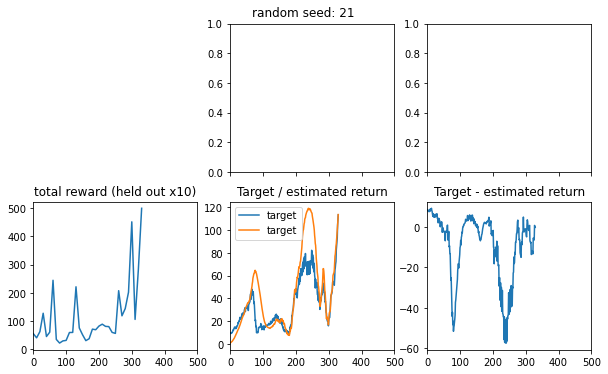

/home/aaron/anaconda3/envs/PT17/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


step: 10 test result: 21.9
step: 20 test result: 41.5
step: 30 test result: 60.3
step: 40 test result: 126.5
step: 50 test result: 88.9
step: 60 test result: 49.3
step: 70 test result: 80.1
step: 80 test result: 72.4
step: 90 test result: 317.9
step: 100 test result: 273.8
step: 110 test result: 89.2
step: 120 test result: 198.6
step: 130 test result: 208.2
step: 140 test result: 438.0
step: 150 test result: 123.1
step: 160 test result: 120.3
step: 170 test result: 107.4
step: 180 test result: 48.8
step: 190 test result: 36.9
step: 200 test result: 28.8
step: 210 test result: 47.6
step: 220 test result: 54.5
step: 230 test result: 61.0
step: 240 test result: 88.8
step: 250 test result: 168.4
step: 260 test result: 194.4
step: 270 test result: 93.5
step: 280 test result: 77.3
step: 290 test result: 36.5
step: 300 test result: 37.7
step: 310 test result: 39.0
step: 320 test result: 25.8
step: 330 test result: 17.7
step: 340 test result: 14.4
step: 350 test result: 13.9
step: 360 test res

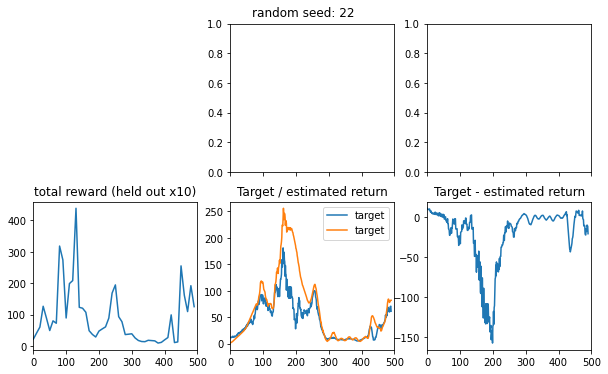

/home/aaron/anaconda3/envs/PT17/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


step: 10 test result: 9.9
step: 20 test result: 11.3
step: 30 test result: 14.6
step: 40 test result: 16.9
step: 50 test result: 18.6
step: 60 test result: 27.7
step: 70 test result: 32.5
step: 80 test result: 187.5
step: 90 test result: 16.8
step: 100 test result: 9.2
step: 110 test result: 9.1
step: 120 test result: 9.3
step: 130 test result: 9.7
step: 140 test result: 9.3
step: 150 test result: 9.6
step: 160 test result: 9.1
step: 170 test result: 22.8
step: 180 test result: 17.8
step: 190 test result: 9.4
step: 200 test result: 9.3
step: 210 test result: 10.6
step: 220 test result: 13.5
step: 230 test result: 25.1
step: 240 test result: 212.8
step: 250 test result: 40.5
step: 260 test result: 40.3
step: 270 test result: 46.8
step: 280 test result: 38.0
step: 290 test result: 128.2
step: 300 test result: 223.0
step: 310 test result: 131.3
step: 320 test result: 69.4
step: 330 test result: 77.8
step: 340 test result: 99.8
step: 350 test result: 123.3
step: 360 test result: 261.8
step

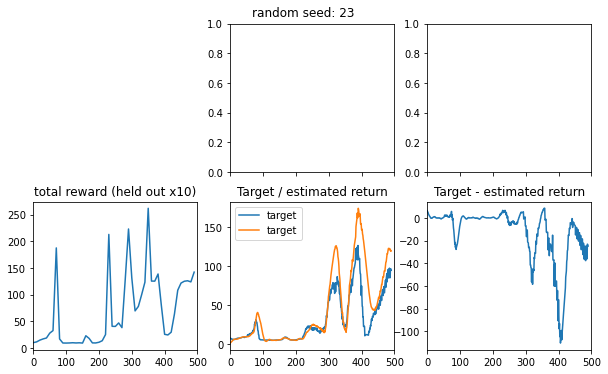

/home/aaron/anaconda3/envs/PT17/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


step: 10 test result: 9.0
step: 20 test result: 31.6
step: 30 test result: 67.3
step: 40 test result: 70.3
step: 50 test result: 193.8
step: 60 test result: 196.2
step: 70 test result: 85.5
step: 80 test result: 117.6
step: 90 test result: 110.3
step: 100 test result: 65.9
step: 110 test result: 74.6
step: 120 test result: 169.6
step: 130 test result: 106.3
step: 140 test result: 124.0
step: 150 test result: 171.1
step: 160 test result: 164.7
step: 170 test result: 112.5
step: 180 test result: 149.7
step: 190 test result: 415.9
step: 200 test result: 416.3
step: 210 test result: 414.9
step: 220 test result: 212.4
step: 230 test result: 391.9
step: 240 test result: 166.3
step: 250 test result: 143.4
step: 260 test result: 154.8
step: 270 test result: 164.9
step: 280 test result: 198.1
step: 290 test result: 161.9
step: 300 test result: 164.6
step: 310 test result: 181.1
step: 320 test result: 241.8
step: 330 test result: 304.8
step: 340 test result: 500.0


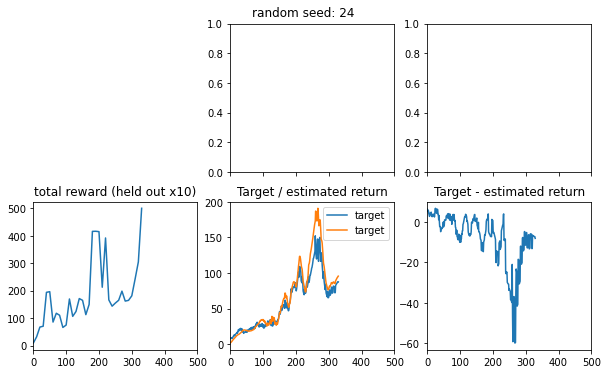

/home/aaron/anaconda3/envs/PT17/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


step: 10 test result: 9.2
step: 20 test result: 9.3
step: 30 test result: 9.4
step: 40 test result: 9.4
step: 50 test result: 9.3
step: 60 test result: 9.3
step: 70 test result: 9.4
step: 80 test result: 9.3
step: 90 test result: 9.0
step: 100 test result: 15.4
step: 110 test result: 16.7
step: 120 test result: 32.3
step: 130 test result: 137.3
step: 140 test result: 71.2
step: 150 test result: 112.3
step: 160 test result: 59.2
step: 170 test result: 72.1
step: 180 test result: 187.5
step: 190 test result: 500.0


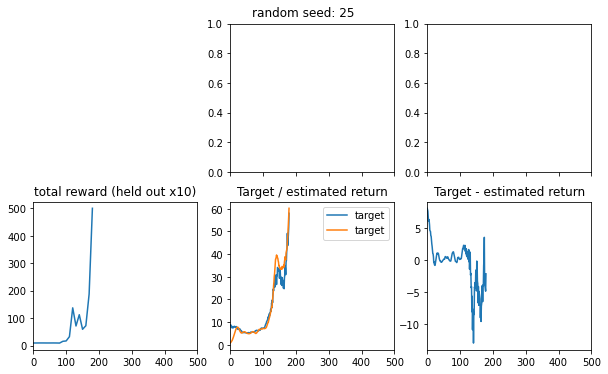

/home/aaron/anaconda3/envs/PT17/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


step: 10 test result: 23.9
step: 20 test result: 20.7
step: 30 test result: 86.5
step: 40 test result: 75.9
step: 50 test result: 71.6
step: 60 test result: 35.7
step: 70 test result: 72.0
step: 80 test result: 61.8
step: 90 test result: 108.6
step: 100 test result: 115.2
step: 110 test result: 118.0
step: 120 test result: 39.1
step: 130 test result: 38.6
step: 140 test result: 58.8
step: 150 test result: 106.5
step: 160 test result: 128.7
step: 170 test result: 238.7
step: 180 test result: 263.3
step: 190 test result: 328.4
step: 200 test result: 500.0


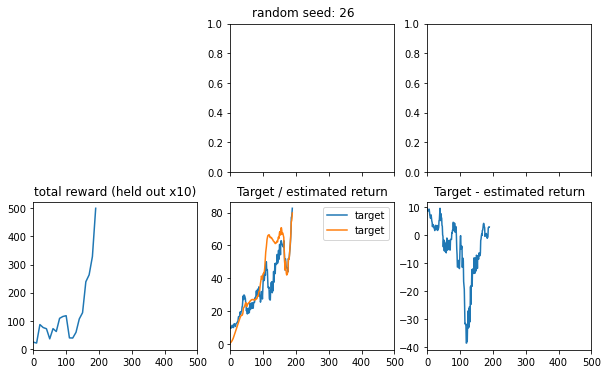

/home/aaron/anaconda3/envs/PT17/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


step: 10 test result: 9.3
step: 20 test result: 9.6
step: 30 test result: 9.3
step: 40 test result: 9.0
step: 50 test result: 46.8
step: 60 test result: 343.8
step: 70 test result: 89.8
step: 80 test result: 66.2
step: 90 test result: 410.6
step: 100 test result: 500.0


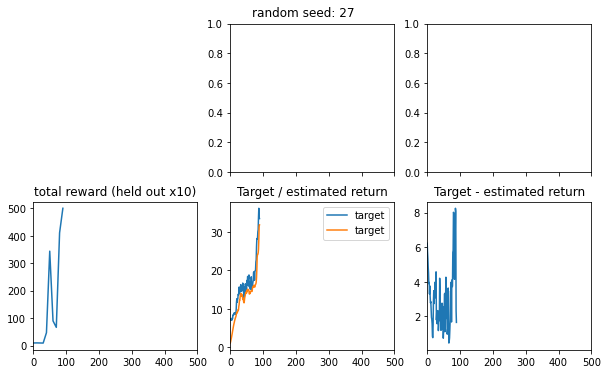

/home/aaron/anaconda3/envs/PT17/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


step: 10 test result: 37.0
step: 20 test result: 47.3
step: 30 test result: 88.1
step: 40 test result: 48.7
step: 50 test result: 104.3
step: 60 test result: 455.3
step: 70 test result: 500.0


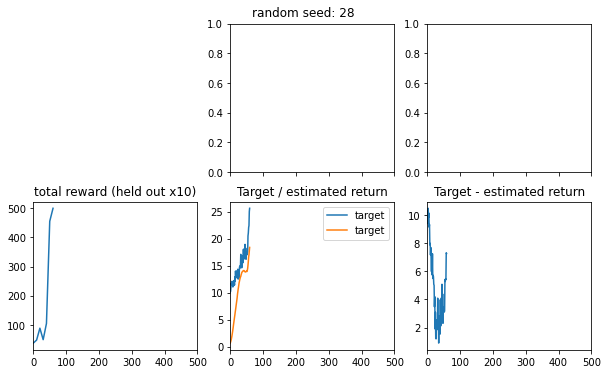

/home/aaron/anaconda3/envs/PT17/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


step: 10 test result: 9.7
step: 20 test result: 9.4
step: 30 test result: 22.1
step: 40 test result: 159.3
step: 50 test result: 45.7
step: 60 test result: 53.6
step: 70 test result: 53.3
step: 80 test result: 373.8
step: 90 test result: 66.8
step: 100 test result: 39.4
step: 110 test result: 380.1
step: 120 test result: 115.4
step: 130 test result: 384.1
step: 140 test result: 89.8
step: 150 test result: 104.5
step: 160 test result: 109.3
step: 170 test result: 119.9
step: 180 test result: 143.4
step: 190 test result: 98.1
step: 200 test result: 16.8
step: 210 test result: 9.8
step: 220 test result: 9.5
step: 230 test result: 9.6
step: 240 test result: 9.4
step: 250 test result: 9.5
step: 260 test result: 9.2
step: 270 test result: 9.2
step: 280 test result: 9.5
step: 290 test result: 9.3
step: 300 test result: 9.8
step: 310 test result: 9.6
step: 320 test result: 9.3
step: 330 test result: 9.6
step: 340 test result: 9.2
step: 350 test result: 9.8
step: 360 test result: 9.2
step: 370 

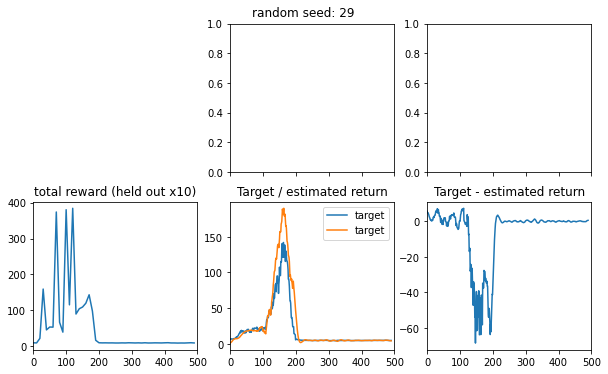

In [3]:
for random_seed in range(30):
    gamma_buffer, angle_buffer, target_value_buffer, estimate_value_buffer, test_results = run(random_seed)
    fig, axes = plt.subplots(2, 3, figsize=(10,6), sharex=True)
    fig.suptitle("random seed: " + str(random_seed), y=0.92)
    axes[1,0].plot(np.arange(len(test_results))*10, test_results)
    axes[1,0].set_xlim([0,500])
    axes[1,0].set_title("total reward (held out x10)")d
    axes[1,1].plot(mv(target_value_buffer, 10), label="target")
    axes[1,1].plot(mv(estimate_value_buffer, 10), label="target")
    axes[1,1].legend()
    axes[1,1].set_title("Target / estimated return")
    axes[1,2].plot(mv(target_value_buffer-estimate_value_buffer,10))
    axes[1,2].set_title("Target - estimated return")
    axes[0,0].axis("off")
    plt.savefig("Naive rs-{}".format(random_seed))
    plt.pause(0.1)

In [4]:
render = True

n_episodes = 10
for i_episode in range(1, n_episodes+1):
    running_reward = 0
    state = test_task.reset()
    for test_step in range(500):
        softmax_action = torch.exp(actor_network(Variable(torch.Tensor([state]))))
        action = np.argmax(softmax_action.data.numpy()[0])
        next_state,reward,done,_ = test_task.step(action)
        result += reward
        state = next_state
        if done:
            break
        if render:
            test_task.render()
    print('Episode {}\tReward: {}'.format(i_episode, running_reward))
    test_task.reset()
    render()
    break

NameError: name 'test_task' is not defined